In [1081]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

In [1082]:
df = pd.read_pickle("./shows_df_final2.pkl")

In [1083]:
df.columns

Index(['link', 'imdb_rating', 'title', 's01_episodes', 'avg_runtime', 'genres',
       'rel_date', 'certification', 'origin', 'company', 'creators',
       'creators_a', 'stars', 'stars_a'],
      dtype='object')

# DATA CLEANING, PREPARATION AND INITIAL EXPLORATIONS

GENRES

In [1084]:
genres_l = set(df.genres.sum())

In [1085]:
def m(x):
    if i in x:
        return 1
    else:
        return 0
    
for i in genres_l:
    df[i] = df.genres.apply(m)

In [1086]:
df[['imdb_rating'] + list(genres_l)].corr().iloc[:,0]

imdb_rating    1.000000
Crime          0.038813
Romance        0.045513
Comedy         0.022244
News           0.069006
Adventure     -0.001700
Sport          0.071994
Sci-Fi        -0.105571
Game-Show     -0.053298
Musical       -0.054243
Mystery       -0.006094
Reality-TV    -0.082501
Western        0.036265
History        0.051376
Short         -0.053239
Drama          0.033611
Action         0.000980
Biography      0.067982
Animation      0.038486
Horror        -0.100276
Fantasy        0.004190
Music          0.014045
Family        -0.048417
War            0.014827
Talk-Show     -0.009340
Thriller       0.034059
Documentary    0.027008
Name: imdb_rating, dtype: float64

In [1087]:
df.rename(columns={"Talk-Show": "Talk_Show", "Sci-Fi": "Sci_Fi", "Game-Show": "Game_Show", "Reality-TV":"Reality_TV"}, inplace=True)

RELEASE DATE

In [1088]:
df['rel_month']= pd.DatetimeIndex(df['rel_date']).month #creating release month column

CERTIFICATION

In [1089]:
#after exploration looks like over 457 of the shows have no certification info, still will keep that column to anlyse shows that have certification info
df['certification'][df.certification.apply(len)>7] = "0"
df['certification'][df.certification==''] = "0"

#unification of the certification
df['certification'][df.certification=='TV-Y7'] = "TV-PG"
df['certification'][df.certification=='TV-G'] = "TV-PG"
df['certification'][df.certification=='TV-Y'] = "TV-PG"
df['certification'][df.certification=='PG'] = "TV-PG"
df['certification'][df.certification=='PG-13'] = "TV-14"

df.certification.value_counts()

/var/folders/vr/n5366ypx2jd2xjt2gj07clnh0000gn/T/ipykernel_36167/1279704069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['certification'][df.certification.apply(len)>7] = "0"
/var/folders/vr/n5366ypx2jd2xjt2gj07clnh0000gn/T/ipykernel_36167/1279704069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['certification'][df.certification==''] = "0"
/var/folders/vr/n5366ypx2jd2xjt2gj07clnh0000gn/T/ipykernel_36167/1279704069.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

0        456
TV-MA    446
TV-14    314
TV-PG    139
Name: certification, dtype: int64

In [1090]:
df['TV_PG'] = (df['certification'] == 'TV-PG').apply(int)
df['TV_14'] = (df['certification'] == 'TV-14').apply(int)
df['TV_MA'] = (df['certification'] == 'TV-MA').apply(int)

ORIGIN

In [1091]:
df.origin.value_counts()
# I will simplyfy that column to boolean 'made_in_usa'

United States             517
India                     158
United Kingdom            133
Japan                      85
South Korea                83
Turkey                     63
Spain                      28
Sweden                     20
Canada                     19
Italy                      17
Australia                  17
China                      17
France                     17
Norway                     15
Thailand                   14
Iran                       14
Germany                    13
Serbia                     12
Mexico                     12
Denmark                    11
Brazil                     10
Pakistan                    7
Egypt                       5
Taiwan                      5
Ireland                     5
South Africa                4
Russia                      4
Israel                      4
Belgium                     3
New Zealand                 3
Bangladesh                  3
Colombia                    3
Poland                      3
Netherland

In [1092]:
df['made_in_usa'] = (df.origin == 'United States').apply(int)

In [1093]:
df[['imdb_rating', 'made_in_usa']].corr()

,imdb_rating,made_in_usa
imdb_rating,1.000000,-0.169572
made_in_usa,-0.169572,1.000000


PRODUCING COMPANY - feature choosen in third scrape, after realising that the factors may be not sufficient for prediction I created number of awards feature first and "big producing company" feature after

In [1094]:
from collections import Counter
comp = pd.DataFrame(Counter(df.company.sum()), index=[0]).T
comp[0].sort_values(ascending=False).head(50)

Netflix                                   68
Amazon Studios                            31
Studio Dragon                             23
Universal Television                      21
CBS Television Studios                    20
3 Arts Entertainment                      20
ABC Signature                             17
ALTBalaji                                 17
Warner Bros. Television                   16
Netflix Studios                           15
Applause Entertainment Ltd.               15
Lionsgate Television                      14
British Broadcasting Corporation (BBC)    14
BBC Studios                               14
20th Television                           11
JTBC Studios                              11
Home Box Office (HBO)                     10
Sony Pictures Television                  10
MX Player                                 10
20th Century Fox Television                9
Ay Yapim                                   9
Berlanti Productions                       8
Paramount 

In [1095]:
company_l = ['Netflix', 'Netflix Studios', 'Amazon Studios', 'Studio Dragon', 'Universal Television', 'CBS Television Studios', '3 Arts Entertainment', 'ABC Signature', 'ALTBalaji', 'Warner Bros. Television', ' Applause Entertainment Ltd.', 'Lionsgate Television', 'British Broadcasting Corporation (BBC)', 'BBC Studios', '20th Television', 'JTBC Studios', 'Home Box Office (HBO)', 'Sony Pictures Television', 'MX Player', '20th Century Fox Television', 'Paramount Television', 'Fox Entertainment', 'Netflix Animation', 'Warner Bros. Animation']
#list of big companies is based on number of shows prodeuced in observed time (min 10)

def c(x):
    for i in company_l:
        if i in x:
            return 1
        else:
            return 0
    

df['big_c'] = df.company.apply(c)

df[df.big_c==1]

,link,imdb_rating,title,s01_episodes,avg_runtime,genres,rel_date,certification,origin,company,...,War,Talk_Show,Thriller,Documentary,rel_month,TV_PG,TV_14,TV_MA,made_in_usa,big_c
2,https://www.imdb.com/title/tt8115560,6.6,Tidying Up with Marie Kondo,8,40,[Reality-TV],2019-01-01,TV-PG,United States,"[Netflix, The Jackal Group]",...,0,0,0,0,1,1,0,0,1,1
51,https://www.imdb.com/title/tt1312171,8.0,The Umbrella Academy,10,60,"[Action, Adventure, Comedy]",2019-02-15,TV-14,United States,"[Dark Horse Entertainment, Netflix, Universal ...",...,0,0,0,0,2,0,1,0,1,1
86,https://www.imdb.com/title/tt9561862,8.4,"Love, Death & Robots",18,15,"[Animation, Short, Action]",2019-03-15,TV-MA,United States,"[Blur Studio, Netflix Studios, Netflix]",...,0,0,0,0,3,0,0,1,1,1
114,https://www.imdb.com/title/tt9184994,7.9,How to Sell Drugs Online (Fast),6,30,"[Comedy, Crime, Drama]",2019-05-31,TV-MA,Germany,"[Bildundtonfabrik, Netflix]",...,0,0,0,0,5,0,0,1,0,1
123,https://www.imdb.com/title/tt7087260,7.4,Tales of the City,10,60,[Drama],2019-06-07,TV-MA,United States,"[Netflix, Sweetpants Productions, Working Titl...",...,0,0,0,0,6,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,https://www.imdb.com/title/tt14163838,6.4,Feels Like Ishq,6,32,"[Comedy, Drama, Romance]",2021-07-23,TV-MA,India,"[Awesomeness TV, Mutant Films, Netflix]",...,0,0,0,0,7,0,0,1,0,1
1187,https://www.imdb.com/title/tt11834150,7.2,The Chair,6,30,"[Comedy, Drama]",2021-08-20,TV-MA,United States,"[BLB Media, Netflix Studios, Netflix]",...,0,0,0,0,8,0,0,1,1,1
1201,https://www.imdb.com/title/tt5540990,6.4,On the Verge,12,35,[Comedy],2021-09-06,TV-14,France,"[The Film TV, Canal+, Netflix]",...,0,0,0,0,9,0,1,0,0,1
1233,https://www.imdb.com/title/tt13278100,7.0,Braqueurs,6,44,"[Action, Crime, Drama]",2021-09-24,TV-MA,France,"[Labyrinthe Films, Netflix]",...,0,0,0,0,9,0,0,1,0,1


AWARDS

In [1096]:
df['creators_a_n']= df.creators_a.apply(sum) #counting awards for creators, stars and sum of them
df['stars_a_n']= df.stars_a.apply(sum)
df['awards_n'] = df['creators_a_n'] + df['stars_a_n']

df.head()

,link,imdb_rating,title,s01_episodes,avg_runtime,genres,rel_date,certification,origin,company,...,Documentary,rel_month,TV_PG,TV_14,TV_MA,made_in_usa,big_c,creators_a_n,stars_a_n,awards_n
0,https://www.imdb.com/title/tt7670568,5.8,The Masked Singer,10,60,"[Game-Show, Music, Reality-TV]",2019-01-02,TV-PG,United States,"[Smart Dog Media, Fox Alternative Entertainmen...",...,0,1,1,0,0,1,0,0,9,9
1,https://www.imdb.com/title/tt8001250,6.2,Siempre Bruja,11,40,"[Drama, Fantasy]",2019-01-01,TV-14,Colombia,[Caracol],...,0,1,0,1,0,0,0,0,0,0
2,https://www.imdb.com/title/tt8115560,6.6,Tidying Up with Marie Kondo,8,40,[Reality-TV],2019-01-01,TV-PG,United States,"[Netflix, The Jackal Group]",...,0,1,1,0,0,1,1,1,1,2
3,https://www.imdb.com/title/tt8324422,8.1,PEN15,10,30,[Comedy],2019-02-08,TV-MA,United States,"[Awesomeness TV, Odenkirk Provissiero Entertai...",...,0,2,0,0,1,1,0,6,7,13
4,https://www.imdb.com/title/tt8888322,6.6,Bloom,6,60,"[Drama, Mystery, Sci-Fi]",2019-01-01,0,Australia,[Playmaker Media],...,0,1,0,0,0,0,0,5,12,17


In [1097]:
df.corr().iloc[:1]

,imdb_rating,s01_episodes,avg_runtime,Crime,Romance,Comedy,News,Adventure,Sport,Sci_Fi,...,Documentary,rel_month,TV_PG,TV_14,TV_MA,made_in_usa,big_c,creators_a_n,stars_a_n,awards_n
imdb_rating,1.0,0.036943,0.076961,0.038813,0.045513,0.022244,0.069006,-0.0017,0.071994,-0.105571,...,0.027008,0.028357,-0.105924,-0.025684,-0.031788,-0.169572,-0.034374,0.001824,0.058789,0.050013


In [1098]:
(pd.Series((df.creators+df.stars).sum()).value_counts() > 3).sum() #it does not seem interesting to explore particular names as in explored time period only 12 artists manageged to work in more than 3 shows

12

In [1099]:
df.columns

Index(['link', 'imdb_rating', 'title', 's01_episodes', 'avg_runtime', 'genres',
       'rel_date', 'certification', 'origin', 'company', 'creators',
       'creators_a', 'stars', 'stars_a', 'Crime', 'Romance', 'Comedy', 'News',
       'Adventure', 'Sport', 'Sci_Fi', 'Game_Show', 'Musical', 'Mystery',
       'Reality_TV', 'Western', 'History', 'Short', 'Drama', 'Action',
       'Biography', 'Animation', 'Horror', 'Fantasy', 'Music', 'Family', 'War',
       'Talk_Show', 'Thriller', 'Documentary', 'rel_month', 'TV_PG', 'TV_14',
       'TV_MA', 'made_in_usa', 'big_c', 'creators_a_n', 'stars_a_n',
       'awards_n'],
      dtype='object')

# EDA, CHOOSING FEATURES FOR REGRESSION MODEL

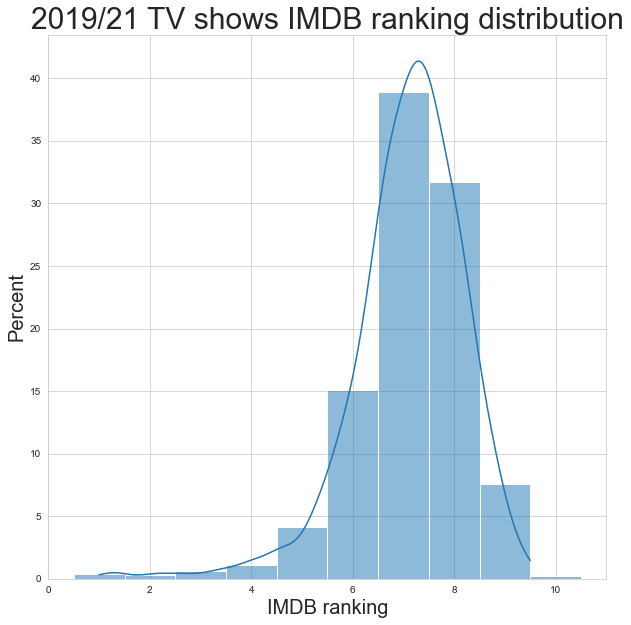

In [1100]:
plt.figure(figsize = [10,10])
sns.set_style("whitegrid")
sns.histplot(df.imdb_rating, stat="percent", discrete=True, kde=True)
plt.title('2019/21 TV shows IMDB ranking distribution',  fontsize = 30)
plt.ylabel('Percent', fontsize = 20)
plt.xlabel('IMDB ranking', fontsize = 20)
plt.savefig('imdb_hist_plot', bbox_inches = 'tight');

In [1101]:
x = df.corr().iloc[:,0]#checking correlations between taget and features
x = list(x[abs(x)>0.05].index)
x

['imdb_rating',
 'avg_runtime',
 'News',
 'Sport',
 'Sci_Fi',
 'Game_Show',
 'Musical',
 'Reality_TV',
 'History',
 'Short',
 'Biography',
 'Horror',
 'TV_PG',
 'made_in_usa',
 'stars_a_n',
 'awards_n']

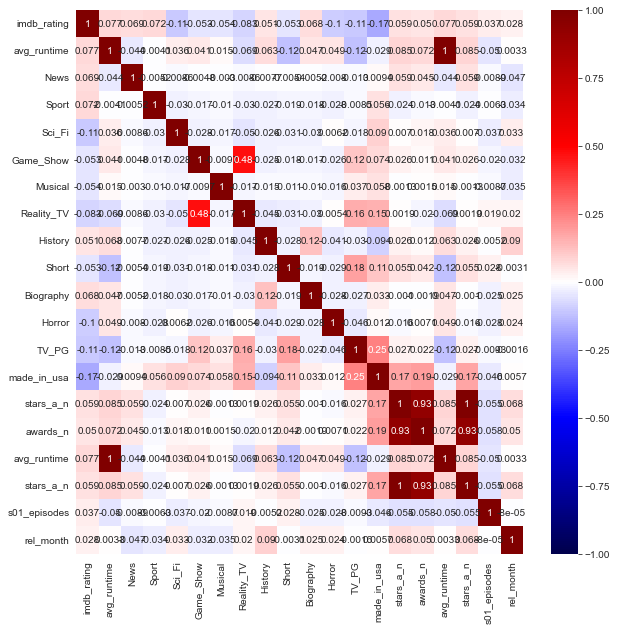

In [1102]:
plt.figure(figsize = [10,10])
sns.heatmap(df[x + ['avg_runtime', 'stars_a_n', 's01_episodes', 'rel_month']].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)
plt.savefig('imdb_heat_map', bbox_inches = 'tight');

<Figure size 720x720 with 0 Axes>

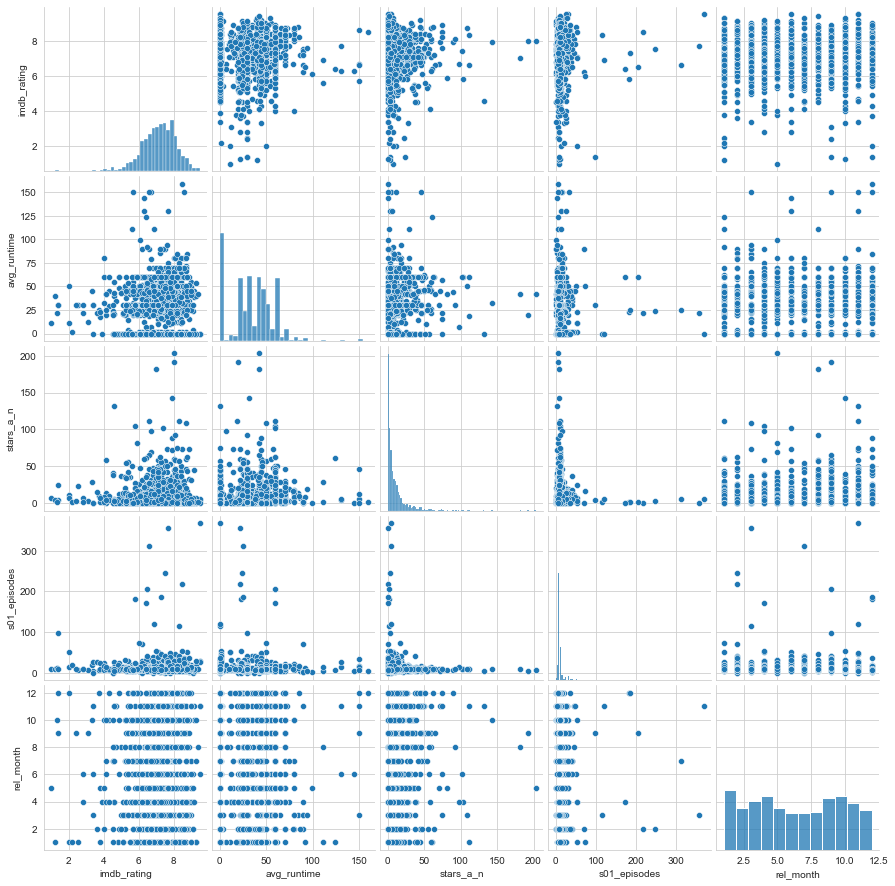

In [1103]:
plt.figure(figsize = [10,10])
sns.pairplot(df[['imdb_rating', 'avg_runtime', 'stars_a_n', 's01_episodes', 'rel_month']])
plt.savefig('imdb_pair_plot', bbox_inches = 'tight');

<AxesSubplot:xlabel='s01_episodes'>

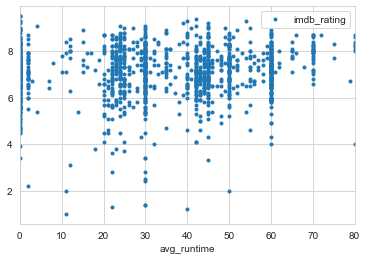

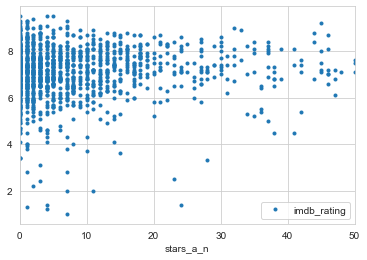

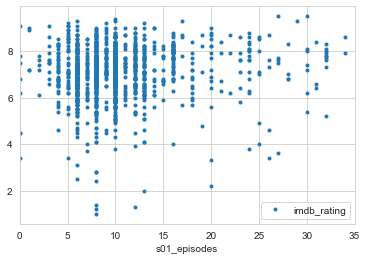

In [1104]:
df.plot(x='avg_runtime',y='imdb_rating',style='.', xlim=(0,80))
df.plot(x='stars_a_n',y='imdb_rating',style='.', xlim=(0,50))
df.plot(x='s01_episodes',y='imdb_rating',style='.', xlim=(0,35))

In [1105]:
df

,link,imdb_rating,title,s01_episodes,avg_runtime,genres,rel_date,certification,origin,company,...,Documentary,rel_month,TV_PG,TV_14,TV_MA,made_in_usa,big_c,creators_a_n,stars_a_n,awards_n
0,https://www.imdb.com/title/tt7670568,5.8,The Masked Singer,10,60,"[Game-Show, Music, Reality-TV]",2019-01-02,TV-PG,United States,"[Smart Dog Media, Fox Alternative Entertainmen...",...,0,1,1,0,0,1,0,0,9,9
1,https://www.imdb.com/title/tt8001250,6.2,Siempre Bruja,11,40,"[Drama, Fantasy]",2019-01-01,TV-14,Colombia,[Caracol],...,0,1,0,1,0,0,0,0,0,0
2,https://www.imdb.com/title/tt8115560,6.6,Tidying Up with Marie Kondo,8,40,[Reality-TV],2019-01-01,TV-PG,United States,"[Netflix, The Jackal Group]",...,0,1,1,0,0,1,1,1,1,2
3,https://www.imdb.com/title/tt8324422,8.1,PEN15,10,30,[Comedy],2019-02-08,TV-MA,United States,"[Awesomeness TV, Odenkirk Provissiero Entertai...",...,0,2,0,0,1,1,0,6,7,13
4,https://www.imdb.com/title/tt8888322,6.6,Bloom,6,60,"[Drama, Mystery, Sci-Fi]",2019-01-01,0,Australia,[Playmaker Media],...,0,1,0,0,0,0,0,5,12,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,https://www.imdb.com/title/tt16385150,8.9,Shark Tank India,36,0,[Reality-TV],2021-12-20,0,India,[],...,0,12,0,0,0,0,0,0,0,0
1351,https://www.imdb.com/title/tt16477402,8.2,WWII in Color: Road to Victory,10,50,"[Documentary, History, War]",2021-12-22,0,United Kingdom,[],...,1,12,0,0,0,0,0,0,0,0
1352,https://www.imdb.com/title/tt11570202,6.9,The Silent Sea,8,45,"[Adventure, Drama, Mystery]",2021-12-24,TV-MA,South Korea,[Artist Studio],...,0,12,0,0,1,0,0,0,13,13
1353,https://www.imdb.com/title/tt13668894,7.3,The Book of Boba Fett,7,38,"[Action, Adventure, Sci-Fi]",2021-12-29,TV-14,United States,"[Golem Creations, Lucasfilm]",...,0,12,0,1,0,1,0,11,5,16


# REGRESSION MODEL

In [1106]:
#y, X = patsy.dmatrices('imdb_rating ~  s01_episodes + avg_runtime + Horror + Romance + Short + Crime + Game_Show + Sport + Documentary + Biography + Musical + Western + Reality_TV + History + Family + Sci_Fi + Thriller+ Animation + News + TV_PG + TV_MA + made_in_usa + stars_a_n + awards_n + big_c', data=df, return_type="dataframe")
y = df.imdb_rating
X = df.drop(columns=['imdb_rating', 'link', 'title', 'genres', 'rel_date', 'certification', 'origin', 'creators', 'stars', 'creators_a', 'stars_a', 'company'], axis=1)
X = sm.add_constant(X).astype(float)

STANDARD SCALER

In [1107]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in ['s01_episodes', 'avg_runtime','creators_a_n', 'stars_a_n', 'awards_n']:
    X[i] = pd.DataFrame(scaler.fit_transform(X[[i]]), columns=[i])


DATA SPIT FOR TESTING

In [1108]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# As there is relatively not a lot of data points, I hold out 25% of the data for final testing, I could proceed with K fold but to keep it simple I stay with that solution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=10)

INITIAL MODEL

In [1109]:
model = sm.OLS(y_train, X_train)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            imdb_rating   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     3.671
Date:                Tue, 12 Jul 2022   Prob (F-statistic):           6.24e-12
Time:                        01:16:43   Log-Likelihood:                -1515.7
No. Observations:                1016   AIC:                             3105.
Df Residuals:                     979   BIC:                             3288.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.1241      0.142     50.098      0.000       6.845       7.403
s01_episodes     0.0616      0.033      1.876      0.061      -0.003       0.126
avg_runtime      0.1169      0.038      3.045      0.002       0.042       0.192
Crime            0.1931      0.098      1.964      0.050       0.000       0.386
Romance          0.1570      0.115      1.364      0.173      -0.069       0.383
Comedy           0.1565      0.098      1.600      0.110      -0.035       0.349
News             3.2248      1.212      2.660      0.008       0.846       5.604
Adventure        0.1951      0.140      1.395      0.163      -0.079       0.470
Sport            0.6772      0.265      2.560      0.011       0.158       1.196
Sci_Fi          -0.3684      0.170     -2.161      0.031      -0.703      -0.034
Game_Show       -0.0906      0.352     -0.257      0.797      -0.782       0.600
Musical         -0.7833      0.455     -1.722      0.085      -1.676       0.109
Mystery         -0.0325      0.116     -0.281      0.779      -0.259       0.194
Reality_TV       0.0833      0.206      0.404      0.686      -0.321       0.488
Western          1.1913      0.786      1.516      0.130      -0.351       2.734
History          0.0824      0.208      0.397      0.692      -0.325       0.490
Short           -0.1106      0.258     -0.429      0.668      -0.617       0.395
Drama            0.0539      0.092      0.586      0.558      -0.127       0.234
Action          -0.1412      0.116     -1.215      0.225      -0.369       0.087
Biography        0.4541      0.276      1.648      0.100      -0.087       0.995
Animation        0.3917      0.133      2.945      0.003       0.131       0.653
Horror          -0.4510      0.200     -2.259      0.024      -0.843      -0.059
Fantasy          0.0535      0.144      0.372      0.710      -0.229       0.336
Music            0.1378      0.253      0.545      0.586      -0.359       0.634
Family          -0.1389      0.259     -0.537      0.591      -0.647       0.369
War              0.0006      0.427      0.001      0.999      -0.838       0.839
Talk_Show       -1.4399      0.508     -2.837      0.005      -2.436      -0.444
Thriller         0.0608      0.121      0.501      0.617      -0.177       0.299
Documentary      0.2294      0.174      1.318      0.188      -0.112       0.571
rel_month        0.0037      0.010      0.370      0.712      -0.016       0.023
TV_PG           -0.3718      0.152     -2.447      0.015      -0.670      -0.074
TV_14           -0.1218      0.110     -1.108      0.268      -0.337       0.094
TV_MA           -0.1113      0.102     -1.096      0.273      -0.311       0.088
made_in_usa     -0.4047      0.090     -4.520      0.000      -0.580      -0.229
big_c            0.0639      0.159      0.401      0.688      -0.249       0.377
creat

In [1110]:
drop_col = ['creators_a_n', 'awards_n', 's01_episodes', 'War', 'Reality_TV', 'Mystery', 'Action', 'Romance', 'Game_Show', 'Family', 'Music', 'History']

#y = df.imdb_rating
#X = X.drop(columns=drop_col, axis=1)

model = sm.OLS(y_train, X_train.drop(columns=drop_col, axis=1))

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            imdb_rating   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     4.911
Date:                Tue, 12 Jul 2022   Prob (F-statistic):           7.23e-14
Time:                        01:16:43   Log-Likelihood:                -1520.7
No. Observations:                1016   AIC:                             3093.
Df Residuals:                     990   BIC:                             3221.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.1642      0.118     60.622      0.000       6.932       7.396
avg_runtime     0.1159      0.038      3.070      0.002       0.042       0.190
Crime           0.1396      0.091      1.526      0.127      -0.040       0.319
Comedy          0.1778      0.088      2.021      0.044       0.005       0.350
News            3.0302      1.207      2.510      0.012       0.661       5.400
Adventure       0.1071      0.129      0.830      0.407      -0.146       0.360
Sport           0.6619      0.262      2.527      0.012       0.148       1.176
Sci_Fi         -0.3805      0.168     -2.265      0.024      -0.710      -0.051
Musical        -0.7328      0.452     -1.621      0.105      -1.620       0.154
Western         1.1977      0.783      1.530      0.126      -0.338       2.734
Short          -0.0725      0.255     -0.284      0.776      -0.572       0.427
Drama           0.0566      0.085      0.668      0.505      -0.110       0.223
Biography       0.4559      0.271      1.680      0.093      -0.077       0.988
Animation       0.3258      0.127      2.564      0.011       0.076       0.575
Horror         -0.4871      0.198     -2.460      0.014      -0.876      -0.099
Fantasy         0.0422      0.142      0.297      0.767      -0.237       0.321
Talk_Show      -1.3410      0.497     -2.699      0.007      -2.316      -0.366
Thriller        0.0226      0.116      0.195      0.845      -0.205       0.250
Documentary     0.2138      0.168      1.275      0.203      -0.115       0.543
rel_month       0.0050      0.010      0.506      0.613      -0.014       0.024
TV_PG          -0.4048      0.143     -2.826      0.005      -0.686      -0.124
TV_14          -0.1395      0.108     -1.292      0.197      -0.351       0.072
TV_MA          -0.1438      0.099     -1.455      0.146      -0.338       0.050
made_in_usa    -0.4089      0.088     -4.629      0.000      -0.582      -0.236
big_c           0.0369      0.158      0.234      0.815      -0.273       0.347
stars_a_n       0.0973      0.035      2.767      0.006       0.028       0.166
==============================================================================
Omnibus:                      306.590   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1232.129
Skew:                          -1.383   Prob(JB):                    2.80e-268
Kurtosis:                       7.632   Cond. No.                         261.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

TEST

In [1111]:
lr=LinearRegression()
lr.fit(X_train.drop(columns=drop_col+['const'], axis=1), y_train)

LinearRegression()

In [1112]:
lr.score(X_train.drop(columns=drop_col+['const'], axis=1), y_train)

0.11034215253325153

In [1113]:
lr.score(X.drop(columns=drop_col+['const'], axis=1), y)

0.08921403273409656

Quick test with Lasso model but does not look promising

In [1114]:
from sklearn.linear_model import LassoCV, RidgeCV

In [1115]:
# Don't forget to standard scale your data for regularized regression
#X_train_poly_scaled = scaler.fit_transform(X_train_poly)


# Fit a LASSO model using polynomial features
lasso = LassoCV()
lasso.fit(X_train.drop(columns=drop_col+['const'], axis=1),y_train)
lasso.score(X_train.drop(columns=drop_col+['const'], axis=1),y_train)

0.08209835198745996

coefficient of determination: 0.08932516554737846
intercept: 7.1240712662120185
slope: [ 9.85501554e-17  6.16209352e-02  1.16862614e-01  1.93145136e-01
  1.56998808e-01  1.56540146e-01  3.22479872e+00  1.95122156e-01
  6.77222900e-01 -3.68384545e-01 -9.06094735e-02 -7.83301400e-01
 -3.25200791e-02  8.33262162e-02  1.19134601e+00  8.24382622e-02
 -1.10613562e-01  5.39361532e-02 -1.41184820e-01  4.54058123e-01
  3.91686727e-01 -4.50982960e-01  5.34614490e-02  1.37791876e-01
 -1.38924817e-01  5.58208617e-04 -1.43990676e+00  6.07952128e-02
  2.29386231e-01  3.67715445e-03 -3.71846408e-01 -1.21773463e-01
 -1.11300945e-01 -4.04690077e-01  6.39450558e-02  1.93095774e-02
  5.17628919e-02  5.08730556e-02]
      Actual  Predicted
1123     6.9   7.141114
593      9.0   7.296508
1182     7.6   6.923580
102      2.8   7.253130
872      6.6   7.130432
...      ...        ...
450      7.9   6.334296
905      8.1   7.495590
968      6.0   7.252976
194      6.7   6.656896
52       6.4   6.934184

[339 

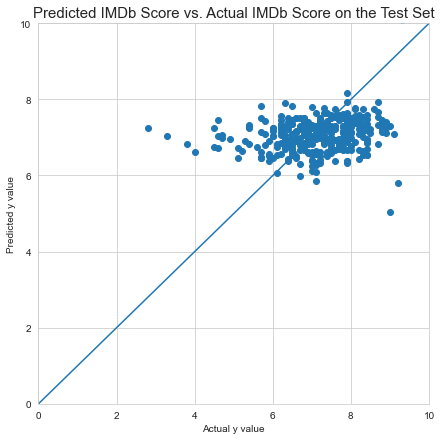

In [1116]:
%matplotlib inline

lr = LinearRegression()
lr.fit(X_train, y_train)

r_sq = lr.score(X, y)
print('coefficient of determination:', r_sq)


print('intercept:', lr.intercept_)
print('slope:', lr.coef_)


y_pred = lr.predict(X_test)

df2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df2)

plt.figure(figsize=(7,7))
plt.title('Predicted IMDb Score vs. Actual IMDb Score on the Test Set', fontsize=15)
plt.ylim(0,10)
plt.xlim(0,10)
plt.xlabel('Actual y value')
plt.ylabel('Predicted y value')
plt.scatter(y_test, y_pred)
plt.plot(range(11), range(11));



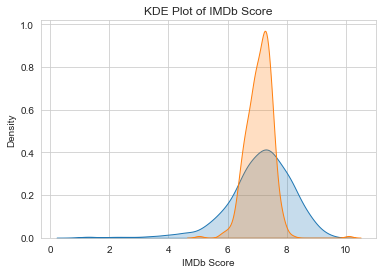

In [1117]:
sns.kdeplot(y, shade=True)
sns.kdeplot(y_pred, shade=True)
plt.title('KDE Plot of IMDb Score')
plt.xlabel('IMDb Score')
plt.ylabel('Density');

In [1118]:
#drop_col = ['creators_a_n', 'awards_n', 's01_episodes', 'War', 'Reality_TV', 'Mystery', 'Action', 'Romance', 'Game_Show', 'Family', 'Music', 'History']
drop_col = ['creators_a_n','Biography','Animation','Comedy','TV_MA','TV_14', 'Thriller','Western','Sport', 'Documentary','rel_month','Short','Drama','Fantasy','Crime','Adventure', 'awards_n', 's01_episodes', 'War', 'Reality_TV', 'Mystery', 'Action', 'Romance', 'Game_Show', 'Family', 'Music', 'History', 'big_c']
#y = df.imdb_rating
#X = X.drop(columns=drop_col, axis=1)

model = sm.OLS(y_train, X_train.drop(columns=drop_col, axis=1))

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            imdb_rating   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     10.84
Date:                Tue, 12 Jul 2022   Prob (F-statistic):           3.33e-16
Time:                        01:16:43   Log-Likelihood:                -1533.0
No. Observations:                1016   AIC:                             3086.
Df Residuals:                    1006   BIC:                             3135.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.3277      0.045    161.937      0.000       7.239       7.417
avg_runtime     0.0995      0.036      2.757      0.006       0.029       0.170
News            3.0997      1.211      2.560      0.011       0.724       5.475
Sci_Fi         -0.5187      0.164     -3.163      0.002      -0.841      -0.197
Musical        -0.7994      0.451     -1.772      0.077      -1.685       0.086
Horror         -0.6111      0.190     -3.212      0.001      -0.984      -0.238
Talk_Show      -1.3939      0.494     -2.823      0.005      -2.363      -0.425
TV_PG          -0.2796      0.119     -2.347      0.019      -0.513      -0.046
made_in_usa    -0.4091      0.075     -5.475      0.000      -0.556      -0.262
stars_a_n       0.0972      0.035      2.793      0.005       0.029       0.165
==============================================================================
Omnibus:                      281.265   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1008.988
Skew:                          -1.302   Prob(JB):                    7.96e-220
Kurtosis:                       7.130   Cond. No.                         39.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""